## Imports

In [365]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import torch
import torch.nn as nn

In [366]:
#gpu check
gpu = 'mps:0' if torch.backends.mps.is_available() else 'cpu'
gpu

'mps:0'

In [367]:
df = pd.read_csv('Amazon.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1997-05-15,0.121875,0.125000,0.096354,0.097917,0.097917,1443120000
1,1997-05-16,0.098438,0.098958,0.085417,0.086458,0.086458,294000000
2,1997-05-19,0.088021,0.088542,0.081250,0.085417,0.085417,122136000
3,1997-05-20,0.086458,0.087500,0.081771,0.081771,0.081771,109344000
4,1997-05-21,0.081771,0.082292,0.068750,0.071354,0.071354,377064000


In [368]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6516 entries, 0 to 6515
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       6516 non-null   object 
 1   Open       6516 non-null   float64
 2   High       6516 non-null   float64
 3   Low        6516 non-null   float64
 4   Close      6516 non-null   float64
 5   Adj Close  6516 non-null   float64
 6   Volume     6516 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 356.5+ KB


In [369]:
df = df[['Date', 'Close']]
df.head()

,Date,Close
0,1997-05-15,0.097917
1,1997-05-16,0.086458
2,1997-05-19,0.085417
3,1997-05-20,0.081771
4,1997-05-21,0.071354


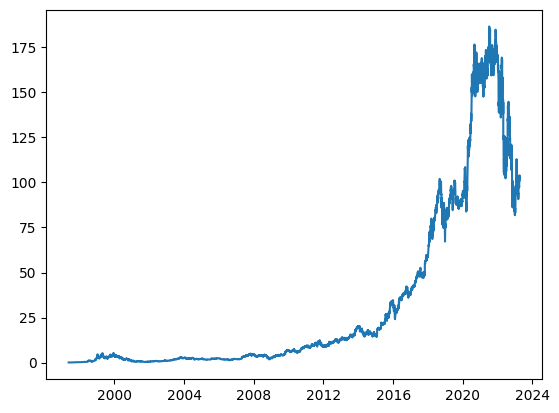

In [370]:
df['Date'] = pd.to_datetime(df['Date'])
plt.plot(df['Date'], df['Close'])
plt.show()

In [371]:
#changing the data to a weekly basis

from copy import deepcopy as dc

def create_data(data, days):
  df_train = dc(df)
  df_train.set_index('Date', inplace=True)
  for i in range(1, days+1):
    df_train[f'Close(t-{i})'] = df_train['Close'].shift(i)
  df_train.dropna(inplace=True)
  return df_train

days = 7
df_train = create_data(df, days)
df_train.head()

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458,0.097917
1997-05-28,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417,0.086458
1997-05-29,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771,0.085417
1997-05-30,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354,0.081771
1997-06-02,0.075521,0.075000,0.075260,0.076563,0.079167,0.075000,0.069792,0.071354


In [372]:
from sklearn.preprocessing import MinMaxScaler  

scaler = MinMaxScaler(feature_range=(-1, 1))
df_train_scaled = scaler.fit_transform(df_train)
df_train_scaled = pd.DataFrame(df_train_scaled, columns=df_train.columns, index=df_train.index)

In [373]:
df_train_scaled.head()

,Close,Close(t-1),Close(t-2),Close(t-3),Close(t-4),Close(t-5),Close(t-6),Close(t-7)
Date,,,,,,,,
1997-05-27,-0.999911,-0.999955,-1.000000,-0.999983,-0.999872,-0.999832,-0.999821,-0.999698
1997-05-28,-0.999939,-0.999911,-0.999944,-1.000000,-0.999983,-0.999872,-0.999832,-0.999821
1997-05-29,-0.999953,-0.999939,-0.999899,-0.999944,-1.000000,-0.999983,-0.999872,-0.999832
1997-05-30,-0.999955,-0.999953,-0.999927,-0.999899,-0.999944,-1.000000,-0.999983,-0.999872
1997-06-02,-0.999950,-0.999955,-0.999941,-0.999927,-0.999899,-0.999944,-1.000000,-0.999983


In [374]:
X = df_train_scaled.drop('Close', axis=1).values
y = df_train_scaled['Close'].values

X.shape, y.shape

((6509, 7), (6509,))

In [375]:
X = dc(np.flip(X, axis=1))
X

array([[-0.99969839, -0.99982128, -0.99983244, ..., -0.99998325,
        -1.        , -0.99995531],
       [-0.99982128, -0.99983244, -0.99987154, ..., -1.        ,
        -0.99994415, -0.99991063],
       [-0.99983244, -0.99987154, -0.99998325, ..., -0.99994415,
        -0.99989946, -0.99993855],
       ...,
       [ 0.05779984,  0.05158   ,  0.0506149 , ...,  0.07431453,
         0.09308121,  0.10690997],
       [ 0.05158   ,  0.0506149 ,  0.04203581, ...,  0.09308121,
         0.10691495,  0.09747299],
       [ 0.0506149 ,  0.04203581,  0.07431453, ...,  0.10691495,
         0.09747802,  0.11398769]])

In [376]:
split = int(0.9 * len(X))
split

5858

In [377]:
X_train = X[:split]
X_test = X[split:]

y_train = y[:split]
y_test = y[split:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5858, 7), (651, 7), (5858,), (651,))

In [378]:
X_train = X_train.reshape(-1, 7, 1)
X_test = X_test.reshape(-1, 7, 1)

y_train = y_train.reshape(-1, 1)
y_test = y_test.reshape(-1, 1)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5858, 7, 1), (651, 7, 1), (5858, 1), (651, 1))

In [379]:
X_train = torch.tensor(X_train).float() 
X_test = torch.tensor(X_test).float() 
y_train = torch.tensor(y_train).float() 
y_test = torch.tensor(y_test).float() 

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([5858, 7, 1]),
 torch.Size([651, 7, 1]),
 torch.Size([5858, 1]),
 torch.Size([651, 1]))

In [380]:
from torch.utils.data import DataLoader, Dataset 

class StockDataset(Dataset):
  def __init__(self, X, y):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return self.X[idx], self.y[idx]
  
train_data = StockDataset(X_train, y_train)
test_data = StockDataset(X_test, y_test)

In [381]:
batch_size = 16

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False)

In [382]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, 
                            batch_first=True)
        
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(gpu)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(gpu)
        
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(1, 4, 1)
model.to(gpu)
model

LSTM(
  (lstm): LSTM(1, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [383]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = nn.MSELoss()

def train_one_epoch(epoch):
    model.train(True)
    running_loss = 0.0
    print(f'Epoch: {epoch + 1}')
    
    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(gpu), batch[1].to(gpu)
        
        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99:  # print every 100 batches
            avg_loss_across_batches = running_loss / 100
            print('Batch {0}, Loss: {1:.3f}'.format(batch_index+1,
                                                    avg_loss_across_batches))
            running_loss = 0.0
    print()

In [384]:
def validate_one_epoch():
    model.train(False)
    running_loss = 0.0
    
    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(gpu), batch[1].to(gpu)
        
        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss.item()

    avg_loss_across_batches = running_loss / len(test_loader)
    
    print('Val Loss: {0:.3f}'.format(avg_loss_across_batches))
    print('***************************************************')
    print()

In [385]:
num_epochs = 10

for epoch in range(num_epochs):
    train_one_epoch(epoch)
    validate_one_epoch()

Epoch: 1
Batch 100, Loss: 0.875
Batch 200, Loss: 0.221
Batch 300, Loss: 0.043

Val Loss: 0.256
***************************************************

Epoch: 2
Batch 100, Loss: 0.008
Batch 200, Loss: 0.002
Batch 300, Loss: 0.002

Val Loss: 0.128
***************************************************

Epoch: 3
Batch 100, Loss: 0.002
Batch 200, Loss: 0.002
Batch 300, Loss: 0.002

Val Loss: 0.098
***************************************************

Epoch: 4
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.077
***************************************************

Epoch: 5
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.057
***************************************************

Epoch: 6
Batch 100, Loss: 0.001
Batch 200, Loss: 0.001
Batch 300, Loss: 0.001

Val Loss: 0.043
***************************************************

Epoch: 7
Batch 100, Loss: 0.001
Batch 200, Loss: 0.000
Batch 300, Loss: 0.000

Val Loss: 0.026
*****************

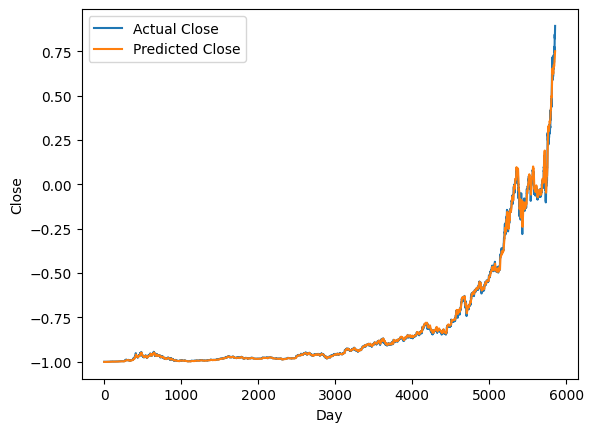

In [386]:
with torch.no_grad():
    predicted = model(X_train.to(gpu)).to('cpu').numpy()

plt.plot(y_train, label='Actual Close')
plt.plot(predicted, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [387]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], days+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([3.65752443e-03, 1.93450628e-03, 1.23418277e-03, ...,
       1.61899672e+02, 1.62477411e+02, 1.63270144e+02])

In [388]:
dummies = np.zeros((X_train.shape[0], days+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([7.91646265e-02, 7.65634249e-02, 7.52572660e-02, ...,
       1.72548002e+02, 1.74955992e+02, 1.76572494e+02])

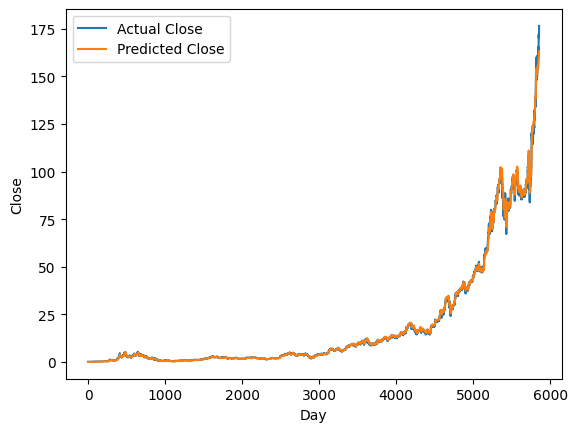

In [389]:
plt.plot(new_y_train, label='Actual Close')
plt.plot(train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()

In [390]:
test_predictions = model(X_test.to(gpu)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], days+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([164.07204192, 163.54382014, 162.41173607, 160.43647362,
       159.83071046, 158.67398167, 157.22541252, 155.92496179,
       155.56384497, 154.72509641, 153.60258899, 152.04445255,
       150.99000991, 151.86338002, 151.47545082, 151.20905554,
       151.79682149, 153.07878035, 153.90624592, 154.5275885 ,
       155.36408603, 155.37698087, 155.93343792, 155.45433883,
       155.76026348, 156.04097649, 157.04156092, 158.93594157,
       160.51755552, 160.98183665, 161.17983367, 160.70214634,
       159.81673734, 159.11806459, 158.19174224, 157.40769116,
       157.13298093, 156.98905889, 157.59597814, 157.16240563,
       157.13955063, 155.68810237, 154.20642904, 153.43886891,
       154.6138339 , 156.17367112, 157.4242766 , 156.87467272,
       155.59417009, 155.49439066, 155.22668922, 154.97966956,
       154.7298486 , 154.57078068, 154.38154326, 154.46506518,
       154.24886531, 154.10457087, 154.14889135, 154.77673693,
       155.3661203 , 155.61361796, 156.19022321, 156.52

In [391]:
dummies = np.zeros((X_test.shape[0], days+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([168.39999674, 164.73100188, 157.49200233, 163.43049557,
       158.75549155, 155.81100359, 155.14849755, 157.80650317,
       153.9050009 , 150.4364931 , 147.74550002, 148.02350066,
       156.44949298, 149.99299379, 150.98950412, 154.7564998 ,
       158.7025004 , 157.24400444, 157.43649336, 161.06300192,
       156.25000082, 159.96000907, 154.99800025, 159.78450022,
       159.52749817, 164.33250669, 172.14649963, 172.18150469,
       168.18550321, 166.93249662, 163.63549582, 160.36050519,
       160.85049265, 159.24699637, 158.82000468, 160.2200014 ,
       160.35200682, 164.31649929, 158.13900677, 160.55050963,
       151.80749309, 150.2240005 , 152.42050404, 162.05800044,
       166.1000065 , 165.56849431, 157.18699477, 151.75100589,
       156.86950922, 155.51400528, 156.44050549, 156.55299635,
       156.78300259, 155.27299395, 155.85099984, 154.96999843,
       154.91949732, 155.90300164, 159.25349382, 159.76699769,
       158.40199492, 161.00399689, 160.17649797, 159.33

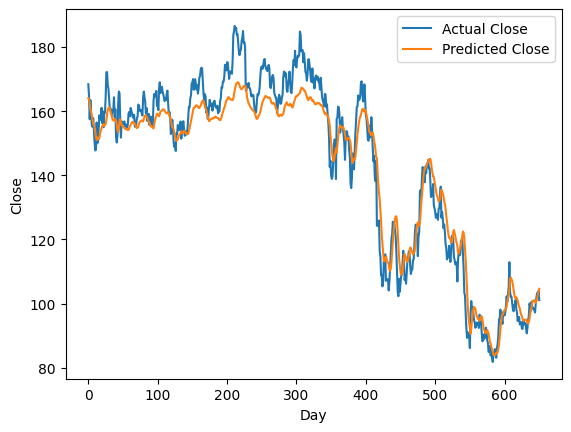

In [392]:
plt.plot(new_y_test, label='Actual Close')
plt.plot(test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.legend()
plt.show()